In [ ]:
import subprocess
import sys

def install_missing_package(package_name):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
    except subprocess.CalledProcessError:
        print(f"Failed to install {package_name}")

# Install required packages
required_packages = [
    "omegaconf",
    "scienceplot",
    "matplotlib",
    "seaborn",
    "numpy",
    "torch",
    "pyyaml",
    "scikit-learn"  # Add sklearn
]

for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_missing_package(package)



from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/your_name/birth")
from model import *
from two_hop_data import *
# import scienceplots

%load_ext autoreload
%autoreload 2


"""values that you need to change"""
PROJECT_PATH = "/home/your_name/TwoHopIC" # the path of your working directory
DATE = "2025-01-13" # the date of the model
layer = 3 # the layer of the model
head = 1 # the head of the model
hopk = 2 # the hopk of the model
steps = 10000 # the steps of the model
DEIVCE = "cuda:3"


In [56]:
device = DEIVCE
torch.cuda.set_device(device)

date = DATE
run_path = f"{PROJECT_PATH}/runs/multi_hop_2_L3_seq_len_24_lr_0.0003"

def load_model(date, depth, layer, head, steps, compute_loss=True, run_path=None):
    if run_path is None:
        run_path = f"{PROJECT_PATH}/runs/{date}layer{layer}head{head}"
    cfg = OmegaConf.load(f"{run_path}/configure.yaml")
    cfg.model_args.dim = 256
    cfg.model_args.n_heads = head
    cfg.model_args.n_layers = layer
    if getattr(cfg.data_args, "max_seq_len", None) == None:
        cfg.data_args.max_seq_len = cfg.data_args.seq_len

    ds = two_hop_format(cfg.data_args)
    cfg.model_args.vocab_size = len(ds.vocab)+len(ds.special_tokens)
    model = Transformer(cfg.model_args)
    model.cuda()
    state_path = f"{run_path}/state_{steps}.pt"
    state = torch.load(state_path, map_location=device)
    model.load_state_dict(state['model_state_dict'])

    seqs, seqs_ans_pos_start, seqs_ans_pos_end = next(iterate_batches(ds, num_workers=48, seed=42, batch_size=512, total_count=1))
    indices = torch.arange(cfg.data_args.max_seq_len).expand(cfg.data_args.batch_size, -1).cuda()

    x = torch.LongTensor(seqs).cuda()
    if compute_loss:
        pred = model(x)
        loss = compute_loss(x, pred, seqs_ans_pos_start, seqs_ans_pos_end, indices)
        print(loss.item())
    return cfg, model, seqs, seqs_ans_pos_start, seqs_ans_pos_end


/tmp/ipykernel_1742771/486003924.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, map_location=device)


Layer 0, Head 0


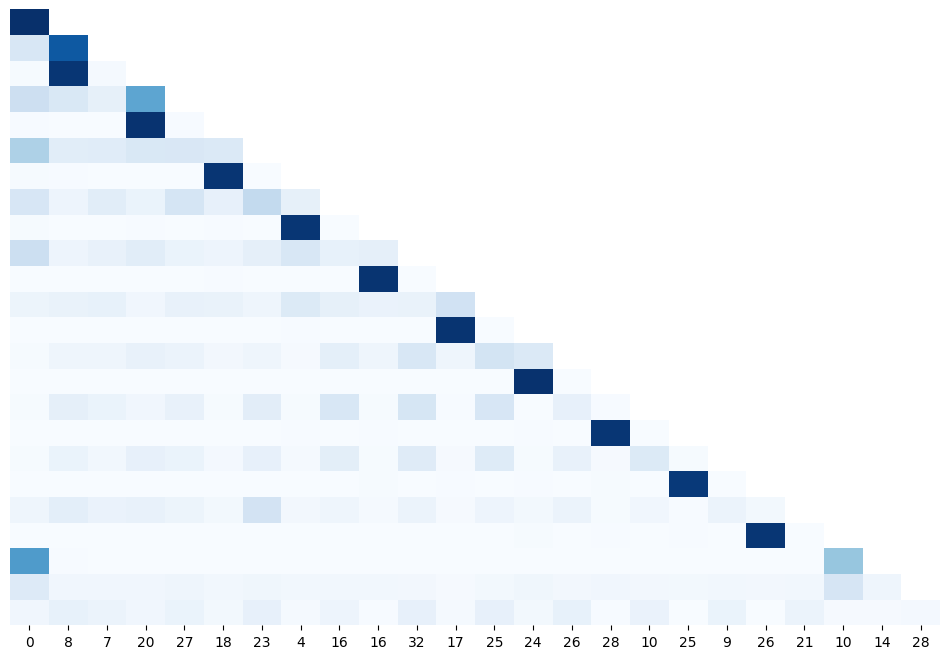

Layer 1, Head 0


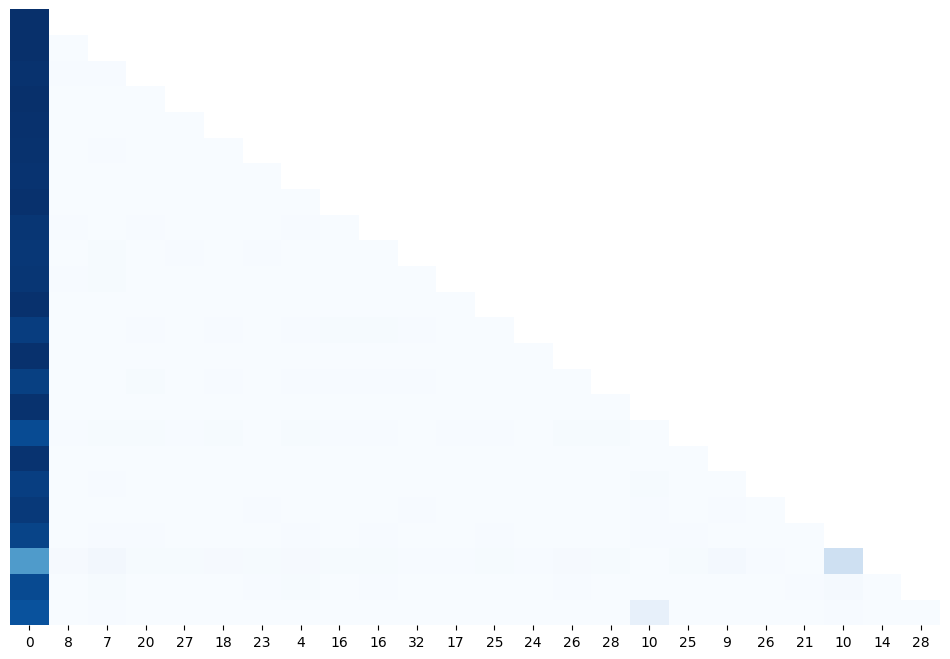

Layer 2, Head 0


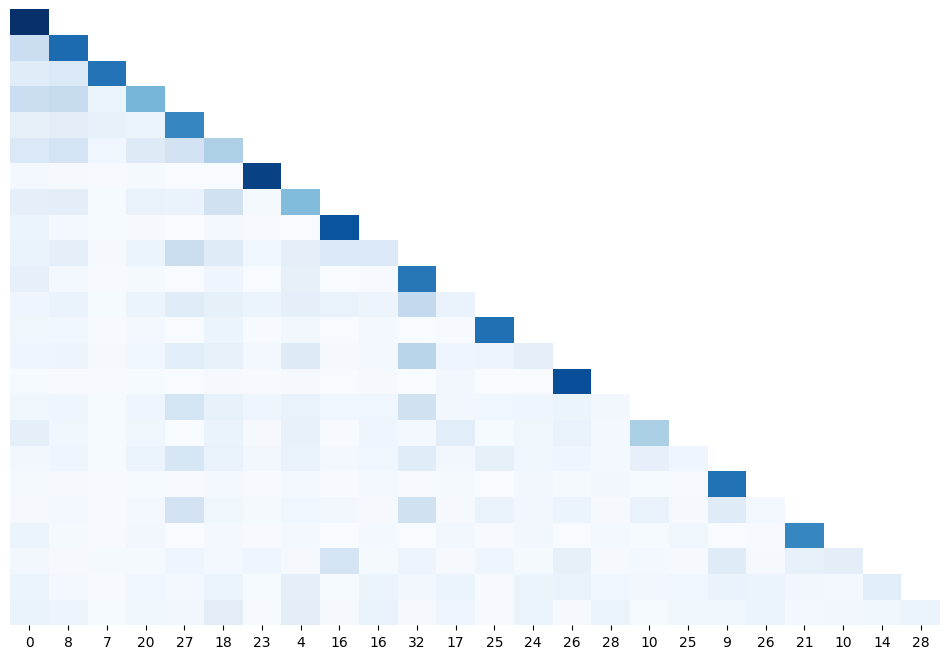

In [64]:
cfg, model, seqs, seqs_ans_pos_start, seqs_ans_pos_end = load_model(date, None, layer, 1, steps, compute_loss=False)
ds = two_hop_format(cfg.data_args)

seqs, seqs_ans_pos_start, seqs_ans_pos_end = next(iterate_batches(ds, num_workers=48, seed=42, batch_size=512, total_count=1))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(torch.LongTensor(seqs)[:, :-1].cuda(), hook)
seq_idx = 2
seq_start = 0
seq_len = 24

for layer_idx in range(layer):
    for head_idx in range(head):
        attns = outputs_list[layer_idx]['attn_weights'].detach().cpu().numpy()
        attns_plot = attns[seq_idx, head_idx, seq_start:seq_len, seq_start:seq_len]
        mask = 1 - np.tril(np.ones_like(attns_plot))
        # label_text = text_test
        print(f"Layer {layer_idx}, Head {head_idx}")
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            attns_plot, mask=mask,
            cmap="Blues", xticklabels=seqs[seq_idx][seq_start:seq_len], yticklabels=[],
            vmin=0, vmax=1, cbar=False, cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect":50, "ticks": [0, 1]}
        )
        plt.show()

In [ ]:
seqs = torch.LongTensor(seqs)
# After getting outputs_list from model.modified_forward_with_hook
token_value_states = {}  # Dict to store value states for each layer
num_layers = layer

# Define helper functions for computing token states and similarities

def compute_token_value_states(outputs_list, seqs, num_layers):
    """Compute token value states for each layer"""
    token_value_states = {}
    for layer_idx in range(num_layers):
        token_value_states[layer_idx] = {}
        value_states = outputs_list[layer_idx]['value_states'].detach()
        
        for token in torch.unique(seqs):
            token_mask = (seqs[:, :-1] == token)
            token_values = value_states.squeeze(1)[token_mask, ...]
            token_value_states[layer_idx][int(token)] = token_values.mean(dim=0)
            
    return token_value_states

def compute_token_embed_states(outputs_list, seqs):
    """Compute token embedding states"""
    token_embed_states = {}
    embed_states = outputs_list[0]['embed_post_pos'].detach()
    
    for token in torch.unique(seqs):
        token_mask = (seqs[:, :-1] == token)
        token_embeds = embed_states[token_mask, ...]
        token_embed_states[int(token)] = token_embeds.mean(dim=0)
    return token_embed_states

def compute_value_embed_similarities(token_value_states, token_embed_states, num_layers):
    """Compute cosine similarities between value and embedding states"""
    token_layer_similarities = {}
    for layer_idx in range(num_layers):
        token_layer_similarities[layer_idx] = {}
        for token in token_value_states[layer_idx].keys():
            value_state = token_value_states[layer_idx][token]
            embed_state = token_embed_states[token]
            similarity = F.cosine_similarity(value_state.flatten(), embed_state.flatten(), dim=0)
            token_layer_similarities[layer_idx][token] = similarity.item()
    return token_layer_similarities

def compute_token_self_probs(model, outputs_list, seqs, num_layers):
    """Compute self-prediction probabilities for each token"""
    token_self_probs = {}
    for layer_idx in range(num_layers):
        token_self_probs[layer_idx] = {}
        value_states = outputs_list[layer_idx]['value_states'].detach()
        
        for token in torch.unique(seqs):
            token_mask = (seqs[:, :-1] == token)
            token_values = value_states.squeeze(1)[token_mask, ...]
            avg_value = token_values.mean(dim=0)
            
            readout = model.layers[layer_idx].attention.wo(avg_value)
            logits = model.output(model.norm(readout))
            probs = torch.nn.functional.softmax(logits, dim=-1)
            
            token_key = int(token)
            token_self_probs[layer_idx][token_key] = probs[token_key].item()
            
    return token_self_probs

# Get all state files from plot_run folder
import glob
import os

state_files = glob.glob(os.path.join('plot_run', '*.pt'))
state_files.sort() # Sort to process in order

all_token_value_states = {}
all_token_embed_states = {}
all_token_layer_similarities = {}
all_token_self_probs = {}

# Process each state file
for state_path in tqdm(state_files):
    print(f"Processing {state_path}")
    
    # Load state
    state = torch.load(state_path, map_location=device)
    model.load_state_dict(state['model_state_dict'])
    
    # Get model outputs
    pred, outputs_list = model.modified_forward_with_hook(torch.LongTensor(seqs)[:, :-1].cuda(), hook)
    
    # Compute metrics
    step = int(state_path.split("state_")[1].replace(".pt", ""))
    all_token_value_states[step] = compute_token_value_states(outputs_list, seqs, num_layers)
    all_token_embed_states[step] = compute_token_embed_states(outputs_list, seqs)
    all_token_layer_similarities[step] = compute_value_embed_similarities(
        all_token_value_states[step], 
        all_token_embed_states[step], 
        num_layers
    )
    all_token_self_probs[step] = compute_token_self_probs(model, outputs_list, seqs, num_layers)


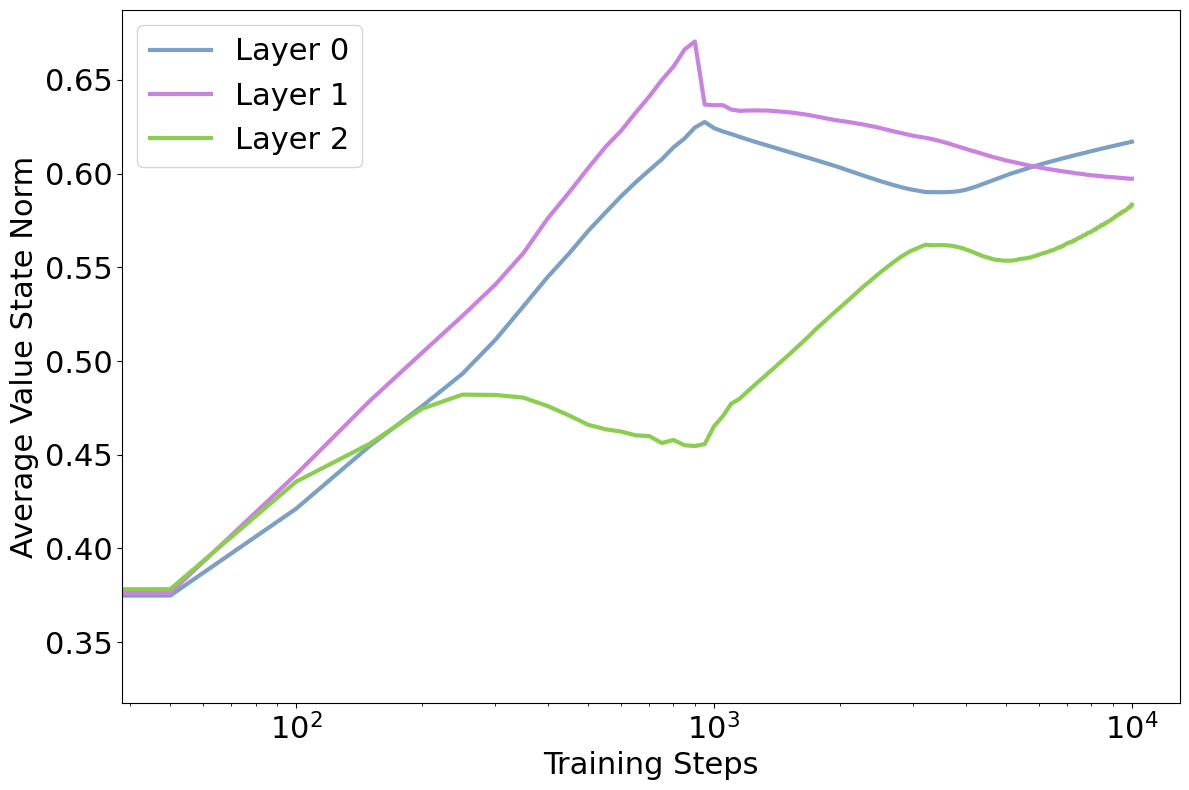

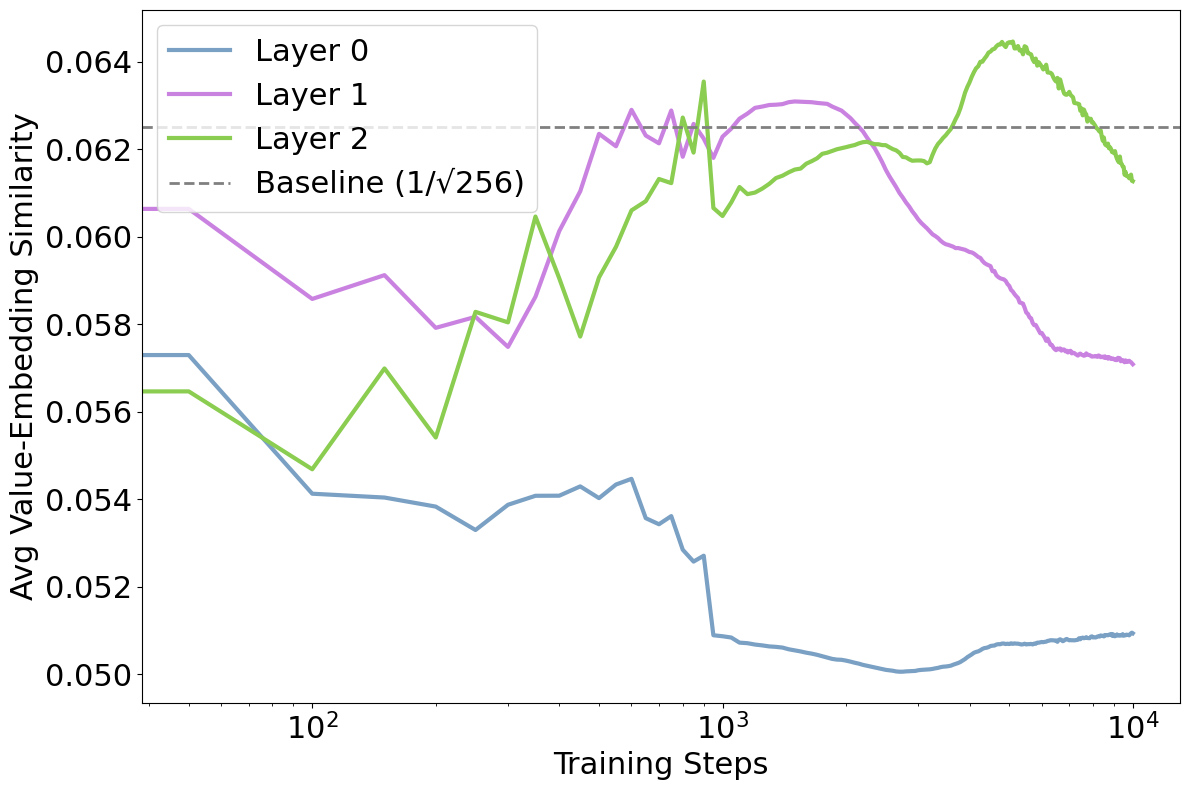

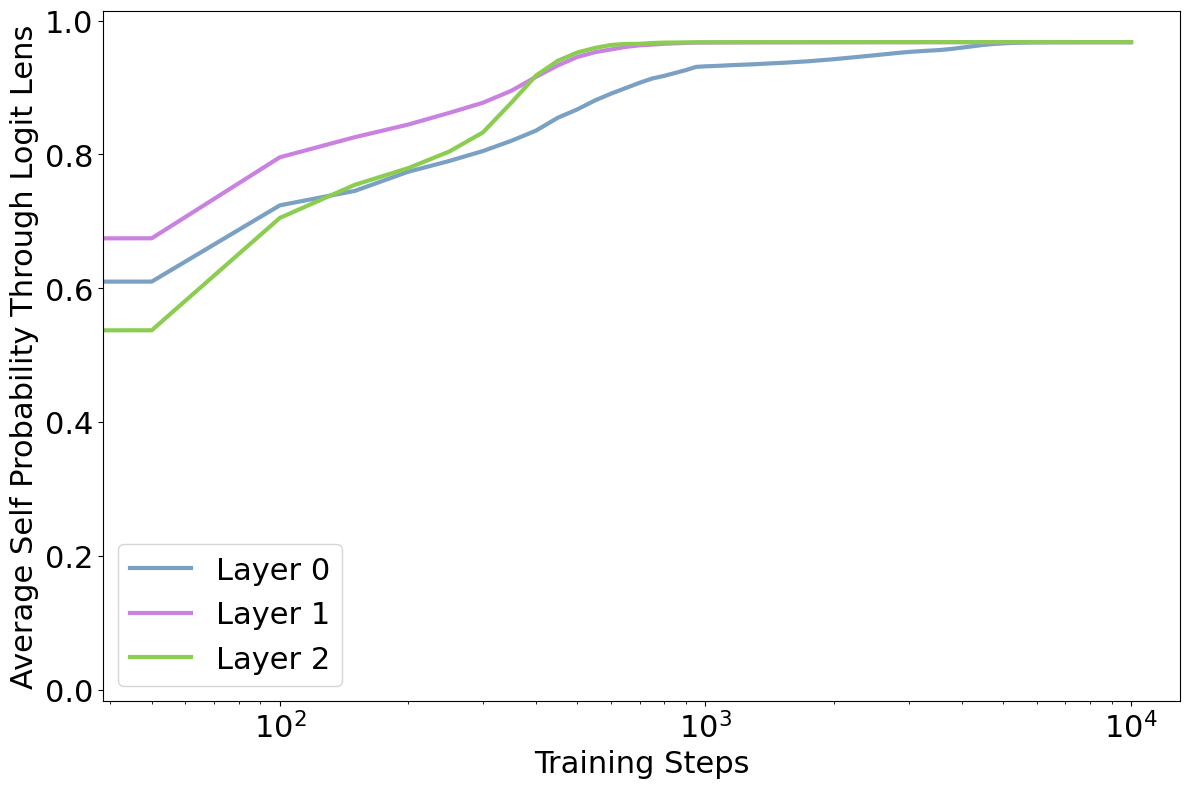

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Convert dictionary steps to sorted list
steps = sorted(list(all_token_value_states.keys()))
num_layers = layer  # Using the layer variable from your setup

# Helper function to compute average across all tokens
def compute_token_average(data_dict, steps, num_layers):
    avg_values = {layer_idx: [] for layer_idx in range(num_layers)}
    
    for step in steps:
        for layer_idx in range(num_layers):
            # Get all token values for this layer and step
            token_values = []
            for value in data_dict[step][layer_idx].values():
                # Move tensor to CPU if it's on GPU
                if torch.is_tensor(value):
                    value = value.cpu().detach().numpy()
                token_values.append(np.abs(value))
            avg_values[layer_idx].append(np.mean(token_values))
    
    return avg_values

# Compute averages for each metric
value_states_avg = compute_token_average(all_token_value_states, steps, num_layers)
similarities_avg = compute_token_average(all_token_layer_similarities, steps, num_layers)
self_probs_avg = compute_token_average(all_token_self_probs, steps, num_layers)

# Plotting parameters
fontsize = 22
linesize = 3
colors =["#7aa0c4", "#ca82e1", "#8bcd50", "#df9f53", "#64b9a1",
        "#745ea6", "#db7e76"]

# 1. Value States Norm Plot
plt.figure(figsize=(12, 8))
for layer_idx in range(num_layers):
    values = value_states_avg[layer_idx]
    plt.plot(steps, values, linewidth=linesize, color=colors[layer_idx], 
             label=f'Layer {layer_idx}')

plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Average Value State Norm', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xscale('log')
plt.tight_layout()
plt.savefig("extra_figures/value_states.pdf", bbox_inches='tight')
plt.show()

# 2. Similarities Plot
plt.figure(figsize=(12, 8))
for layer_idx in range(num_layers):
    similarities = similarities_avg[layer_idx]
    plt.plot(steps, similarities, linewidth=linesize, color=colors[layer_idx],
             label=f'Layer {layer_idx}')

# Add baseline at 1/sqrt(256)
baseline = 1/np.sqrt(256)
plt.axhline(y=baseline, color='gray', linestyle='--', lw=2, label='Baseline (1/√256)')

plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Avg Value-Embedding Similarity', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xscale('log')
plt.tight_layout()
plt.savefig("extra_figures/similarities.pdf", bbox_inches='tight')
plt.show()

# 3. Self Probabilities Plot
plt.figure(figsize=(12, 8))
for layer_idx in range(num_layers):
    probs = self_probs_avg[layer_idx]
    plt.plot(steps, probs, linewidth=linesize, color=colors[layer_idx],
             label=f'Layer {layer_idx}')

plt.xlabel('Training Steps', fontsize=fontsize)
plt.ylabel('Average Self Probability Through Logit Lens', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xscale('log')
plt.tight_layout()
plt.savefig("extra_figures/self_probs.pdf", bbox_inches='tight')
plt.show()
